In [155]:
# import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [156]:
# open the USGS tsv file
# data=pd.read_csv('yellowstone.tsv', sep='\t')

# save as csv
# data.to_csv('yellowstone6192500.csv', index=False)

#This was only needed once to convert the tsv to csv

# EDA
This project is an effort to see if the spring increase in discharge can be predicted from publicly available streamflow, snotel, and weather data.

The Yellowstone river was selected as it is an undammed river with readily accessible data. 

The streamflow data is from the Yellowstone river at Livingston MT. The data is from the USGS and is available at https://waterdata.usgs.gov/mt/nwis/uv?site_no=06192500

The snotel data is from nwcc-ftp.cr.usgs.gov and is available at https://www.wcc.nrcs.usda.gov/nwcc/site?sitenum=384
Data for the following site(s) are contained in this file:
	SNOTEL 384: Canyon, WY
	SNOTEL 670: Northeast Entrance, MT
	SNOTEL 683: Parker Peak, WY
	SNOTEL 806: Sylvan Lake, WY
	SNOTEL 816: Thumb Divide, WY


The weather data is from https://www.ncei.noaa.gov/cdo-web/
The data is from the Livingston, MT weather station. The data is available at https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USC00247212/detail
The data is also from the Yellowstone Lake, MT weather station. The data is available at https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USC00247212/detail

Units:
discharge is in cubic feet per second
snow water equivalent is in inches
temperature is in degrees celsius


In [157]:
# get streamflow data
stream=pd.read_csv('yellowstone6192500.csv')

stream['datetime'] = pd.to_datetime(stream['datetime'])

stream.drop(columns=['timezone', 'agency_cd', 'discharge_quality', 'gage_height_quality'], inplace=True)

# Convert discharge and gage_height columns to numeric
stream['discharge'] = pd.to_numeric(stream['discharge'], errors='coerce')
stream['gage_height'] = pd.to_numeric(stream['gage_height'], errors='coerce')

# Resample the stream data to daily frequency, calculating the mean for discharge and gage height
data = stream.resample('D', on='datetime').mean().reset_index()

print(data.head())

/tmp/ipykernel_167319/1780365280.py:2: DtypeWarning: Columns (4,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  stream=pd.read_csv('yellowstone6192500.csv')


    datetime         id    discharge  gage_height
0 1995-10-01  6192500.0  2205.894737          NaN
1 1995-10-02  6192500.0  2180.729167          NaN
2 1995-10-03  6192500.0  2149.479167          NaN
3 1995-10-04  6192500.0  2253.229167          NaN
4 1995-10-05  6192500.0  2241.770833          NaN


In [158]:
# get snotel data
snotel=pd.read_csv('snotel.csv')
snotel['Date'] = pd.to_datetime(snotel['Date'])
snotel.drop(columns=['Station Id', 'Median Snow Water Equivalent (1991-2020) (in) Start of Day Values'], inplace=True)

# Create new columns for each station's snow water equivalent
stations = snotel['Station Name'].unique()
for station in stations:
    column_name = station.lower().replace(' ', '_') + '_snow'
    snotel[column_name] = snotel.apply(lambda row: row['Snow Water Equivalent (in) Start of Day Values'] if row['Station Name'] == station else np.nan, axis=1)

# Drop the original snow water equivalent column and station name column
snotel.drop(columns=['Station Name', 'Snow Water Equivalent (in) Start of Day Values'], inplace=True)

# Combine rows with the same date   
snotel = snotel.groupby('Date').mean().reset_index()

print(snotel[snotel['Date'] == '2000-01-01'])
print(snotel.head())

           Date  canyon_snow  northeast_entrance_snow  parker_peak_snow  \
1553 2000-01-01          4.6                      5.1               7.1   

      sylvan_lake_snow  thumb_divide_snow  
1553               7.4                4.2  
        Date  canyon_snow  northeast_entrance_snow  parker_peak_snow  \
0 1995-10-01          0.0                      0.0               0.5   
1 1995-10-02          0.0                      0.0               0.3   
2 1995-10-03          0.0                      0.0               0.5   
3 1995-10-04          0.4                      0.0               0.9   
4 1995-10-05          0.4                      0.0               0.9   

   sylvan_lake_snow  thumb_divide_snow  
0               0.0                0.0  
1               0.0                0.0  
2               0.0                0.1  
3               0.0                0.8  
4               0.8                0.8  


In [159]:
# get weather data
weather=pd.read_csv('weather.csv')
weather['DATE'] = pd.to_datetime(weather['DATE'])

# create new columns for each weather station's temperature
stations = weather['STATION'].unique()
for station in stations:
    tmax_column_name = station.lower().replace(' ', '_') + '_tmax'
    tmin_column_name = station.lower().replace(' ', '_') + '_tmin'
    weather[tmax_column_name] = weather.apply(lambda row: row['TMAX'] if row['STATION'] == station else np.nan, axis=1)
    weather[tmin_column_name] = weather.apply(lambda row: row['TMIN'] if row['STATION'] == station else np.nan, axis=1)

# drop the original TMAX and TMIN columns
weather.drop(columns=['TMAX', 'TMIN', 'TAVG', 'TOBS', 'LATITUDE', 'LONGITUDE', 'ELEVATION'], inplace=True)

# combine rows with the same date
numeric_columns = weather.select_dtypes(include=[np.number]).columns
weather = weather.groupby('DATE')[numeric_columns].mean().reset_index()

print(weather.head())

        DATE  usw00024150_tmax  usw00024150_tmin  usc00485345_tmax  \
0 1995-10-01              15.0               7.2               5.6   
1 1995-10-02              13.9              -2.8               7.8   
2 1995-10-03              12.8               7.8               7.8   
3 1995-10-04              10.0               2.2               2.8   
4 1995-10-05              11.7              -2.8               0.6   

   usc00485345_tmin  
0              -1.1  
1              -9.4  
2              -5.6  
3              -7.2  
4              -9.4  


In [160]:
# Merge the snotel data with the discharge data
data = data.merge(snotel[['Date', 'canyon_snow', 'northeast_entrance_snow', 'parker_peak_snow', 'sylvan_lake_snow', 'thumb_divide_snow']],
                  left_on='datetime', right_on='Date', how='left')

# Drop the redundant 'Date' column
data.drop(columns=['Date'], inplace=True)


print(data.head())

    datetime         id    discharge  gage_height  canyon_snow  \
0 1995-10-01  6192500.0  2205.894737          NaN          0.0   
1 1995-10-02  6192500.0  2180.729167          NaN          0.0   
2 1995-10-03  6192500.0  2149.479167          NaN          0.0   
3 1995-10-04  6192500.0  2253.229167          NaN          0.4   
4 1995-10-05  6192500.0  2241.770833          NaN          0.4   

   northeast_entrance_snow  parker_peak_snow  sylvan_lake_snow  \
0                      0.0               0.5               0.0   
1                      0.0               0.3               0.0   
2                      0.0               0.5               0.0   
3                      0.0               0.9               0.0   
4                      0.0               0.9               0.8   

   thumb_divide_snow  
0                0.0  
1                0.0  
2                0.1  
3                0.8  
4                0.8  


In [161]:
# Merge the weather data with the discharge data
data = data.merge(weather[['DATE', 'usw00024150_tmax', 'usw00024150_tmin', 'usc00485345_tmax', 'usc00485345_tmin']],
                  left_on='datetime', right_on='DATE', how='left')
# Drop the redundant 'DATE' column
data.drop(columns=['DATE'], inplace=True)


print(data.head())
print(data.tail())

    datetime         id    discharge  gage_height  canyon_snow  \
0 1995-10-01  6192500.0  2205.894737          NaN          0.0   
1 1995-10-02  6192500.0  2180.729167          NaN          0.0   
2 1995-10-03  6192500.0  2149.479167          NaN          0.0   
3 1995-10-04  6192500.0  2253.229167          NaN          0.4   
4 1995-10-05  6192500.0  2241.770833          NaN          0.4   

   northeast_entrance_snow  parker_peak_snow  sylvan_lake_snow  \
0                      0.0               0.5               0.0   
1                      0.0               0.3               0.0   
2                      0.0               0.5               0.0   
3                      0.0               0.9               0.0   
4                      0.0               0.9               0.8   

   thumb_divide_snow  usw00024150_tmax  usw00024150_tmin  usc00485345_tmax  \
0                0.0              15.0               7.2               5.6   
1                0.0              13.9            

In [162]:
data.to_csv('temp.csv', index=False)

<Axes: xlabel='datetime'>

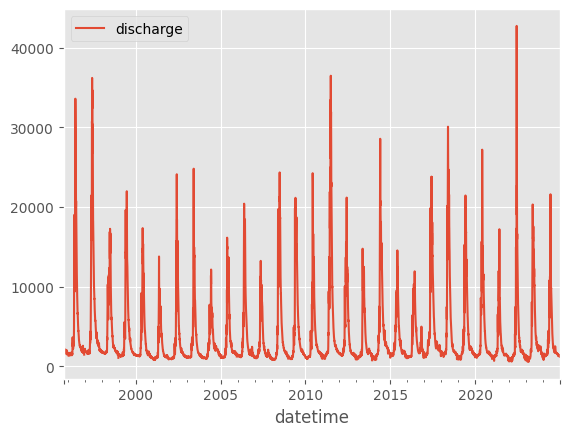

In [163]:
# Convert the discharge column to numeric, coercing errors to NaN
data['discharge'] = pd.to_numeric(data['discharge'], errors='coerce')

# Plot the data
data.plot(x='datetime', y='discharge')

From this chart we can see that there is indeed an increase of discharge every spring.  However, the magnitude of this increase varies quite a bit from year to year.

In [164]:
data['year']=data['datetime'].dt.year

data.head()

,datetime,id,discharge,gage_height,canyon_snow,northeast_entrance_snow,parker_peak_snow,sylvan_lake_snow,thumb_divide_snow,usw00024150_tmax,usw00024150_tmin,usc00485345_tmax,usc00485345_tmin,year
0,1995-10-01,6192500.0,2205.894737,NaN,0.0,0.0,0.5,0.0,0.0,15.0,7.2,5.6,-1.1,1995
1,1995-10-02,6192500.0,2180.729167,NaN,0.0,0.0,0.3,0.0,0.0,13.9,-2.8,7.8,-9.4,1995
2,1995-10-03,6192500.0,2149.479167,NaN,0.0,0.0,0.5,0.0,0.1,12.8,7.8,7.8,-5.6,1995
3,1995-10-04,6192500.0,2253.229167,NaN,0.4,0.0,0.9,0.0,0.8,10.0,2.2,2.8,-7.2,1995
4,1995-10-05,6192500.0,2241.770833,NaN,0.4,0.0,0.9,0.8,0.8,11.7,-2.8,0.6,-9.4,1995


In [165]:
data.groupby(['year']).mean(numeric_only=True)

,id,discharge,gage_height,canyon_snow,northeast_entrance_snow,parker_peak_snow,sylvan_lake_snow,thumb_divide_snow,usw00024150_tmax,usw00024150_tmin,usc00485345_tmax,usc00485345_tmin
year,,,,,,,,,,,,
1995,6192500.0,1907.045078,NaN,4.141304,2.585870,6.890217,5.440217,3.979348,10.341304,-1.469565,1.408696,-10.443333
1996,6192500.0,5968.571239,NaN,8.144809,5.190164,13.505738,11.521858,9.585792,14.842896,-0.017213,8.275232,-7.454375
1997,6192500.0,6764.024373,NaN,8.299452,4.896712,13.639452,12.289315,11.366301,15.110137,1.381370,7.459877,-7.080864
1998,6192500.0,4215.229753,NaN,4.169863,2.532877,7.830411,6.722192,5.630685,16.059452,1.368767,7.697806,-6.569062
1999,6192500.0,4364.890758,NaN,6.079178,3.793699,10.175890,10.648219,7.933151,17.315068,2.150137,7.062333,-8.669767
2000,6192500.0,3394.376057,NaN,4.000273,2.890984,7.125956,6.878962,3.807104,16.080874,0.794809,7.367442,-8.879070
2001,6192500.0,2495.772181,NaN,3.247397,1.515616,5.768219,5.221370,2.540274,15.482192,0.318904,7.413043,-9.025084
2002,6192500.0,3748.841059,NaN,4.457260,1.955068,7.891781,7.129315,4.752329,13.356986,-0.799178,7.600599,-7.794627
2003,6192500.0,3544.478150,NaN,4.558904,2.838082,9.567397,7.752603,5.127671,14.746849,0.096712,9.210802,-6.927077


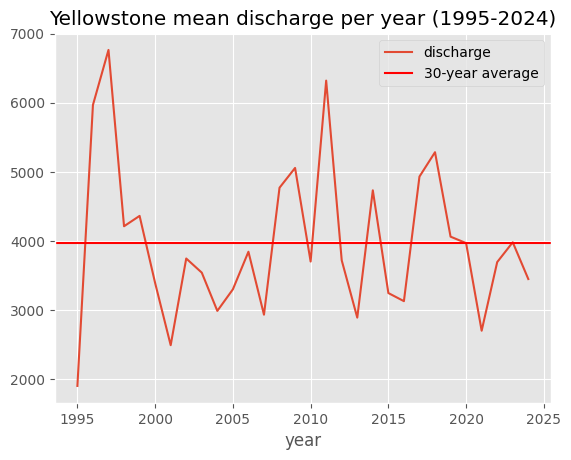

In [166]:
means = data.groupby(['year']).mean(numeric_only=True)
mean_discharge = means['discharge']
overall_mean = mean_discharge.mean()
mean_discharge.plot()
plt.axhline(y=overall_mean, color='red', label='30-year average')
plt.title("Yellowstone mean discharge per year (1995-2024)")
plt.plot(2024, mean_discharge[2024])
plt.legend()

Not only does the magnitude of the spring discharge increase every year, the mean discharge for each year also varies by quite a bit.  This is likely due to the amount of snowpack in the mountains that feed the river.  A potential future question is whether the amount of snowpack can be used to predict the spring discharge increase.  

In [167]:
data['year']

0        1995
1        1995
2        1995
3        1995
4        1995
         ... 
10672    2024
10673    2024
10674    2024
10675    2024
10676    2024
Name: year, Length: 10677, dtype: int32

In [168]:
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['day_of_year'] = data['datetime'].dt.dayofyear

In [169]:
year_2021 = data[data['year'] == 2021]
year_2022 = data[data['year'] == 2022]
year_2023 = data[data['year'] == 2023]
year_2024 = data[data['year'] == 2024]

In [170]:
year_2021

,datetime,id,discharge,gage_height,canyon_snow,northeast_entrance_snow,parker_peak_snow,sylvan_lake_snow,thumb_divide_snow,usw00024150_tmax,usw00024150_tmin,usc00485345_tmax,usc00485345_tmin,year,month,day,day_of_year
9224,2021-01-01,6192500.0,1242.395833,0.700729,4.4,2.9,10.7,7.8,6.1,4.4,-1.0,-3.3,-14.4,2021,1,1,1
9225,2021-01-02,6192500.0,1231.250000,0.682187,4.4,2.9,10.7,7.8,6.2,6.7,-0.5,-6.7,-16.1,2021,1,2,2
9226,2021-01-03,6192500.0,1270.416667,0.736979,4.7,3.1,10.9,7.9,6.3,8.3,-1.0,-5.6,-12.2,2021,1,3,3
9227,2021-01-04,6192500.0,1256.562500,0.718021,4.8,3.1,11.0,8.1,6.5,7.8,1.1,-3.9,-12.2,2021,1,4,4
9228,2021-01-05,6192500.0,1271.562500,0.736562,5.1,3.4,11.3,8.2,6.6,7.2,-2.1,-2.8,-6.1,2021,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9584,2021-12-27,6192500.0,818.833333,0.398333,3.7,1.9,8.3,6.4,7.2,-16.6,-23.8,-6.1,-15.0,2021,12,27,361
9585,2021-12-28,6192500.0,726.333333,NaN,3.8,1.9,8.6,6.9,7.7,-8.2,-21.6,-11.7,-18.9,2021,12,28,362
9586,2021-12-29,6192500.0,627.166667,-0.215806,3.9,1.9,8.7,7.1,7.8,-8.2,-22.1,-10.0,-18.3,2021,12,29,363
9587,2021-12-30,6192500.0,623.666667,-0.132396,4.2,2.0,9.0,7.4,8.1,-2.7,-12.7,-12.8,-16.7,2021,12,30,364


In [171]:
gage_height_2021 = year_2021[['day_of_year', 'gage_height']]
gage_height_2022 = year_2022[['day_of_year', 'gage_height']]
gage_height_2023 = year_2023[['day_of_year', 'gage_height']]
gage_height_2024 = year_2024[['day_of_year', 'gage_height']]

In [172]:
discharge_2021 = year_2021[['day_of_year', 'discharge']]
discharge_2022 = year_2022[['day_of_year', 'discharge']]
discharge_2023 = year_2023[['day_of_year', 'discharge']]
discharge_3_year = discharge_2021.merge(discharge_2022, on='day_of_year').merge(discharge_2023, on='day_of_year')
discharge_3_year.columns = ['day_of_year', 'discharge_2021', 'discharge_2022', 'discharge_2023']

Text(0.5, 0, 'Day of the year')

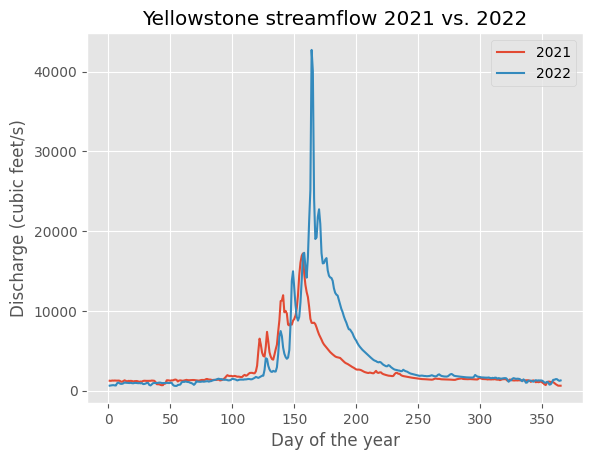

In [173]:
fig, ax = plt.subplots()
ax.plot(discharge_2021['day_of_year'], discharge_2021['discharge'], label='2021')
ax.plot(discharge_2022['day_of_year'], discharge_2022['discharge'], label='2022')
plt.legend()
plt.title('Yellowstone streamflow 2021 vs. 2022')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Day of the year')

This chart examines the 2021 vs the 2022 data.  There is quite a difference between the two.  2021's spring increase started earlier.  2022 had a much higher peak discharge than 2021.  I suspect that the amount of snowpack in the mountains was much less during 2021.  This is a potential future question to investigate.

Text(0.5, 0, 'Day of the year')

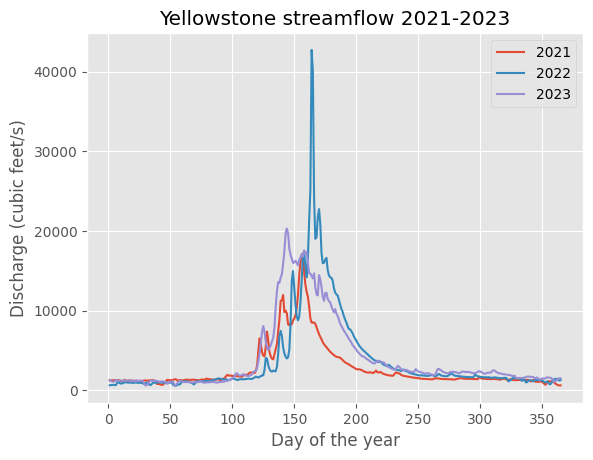

In [174]:
fig, ax = plt.subplots()
ax.plot(discharge_2021['day_of_year'], discharge_2021['discharge'], label='2021')
ax.plot(discharge_2022['day_of_year'], discharge_2022['discharge'], label='2022')
ax.plot(discharge_2023['day_of_year'], discharge_2023['discharge'], label='2023')
plt.legend()
plt.title('Yellowstone streamflow 2021-2023')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Day of the year')

Similar to the previous graph.  2023 data had a similar onset time as 2021.  The peak discharge is slightly more than 2021; bot not anywhere close to 2022.  

In [175]:
discharge=data['discharge'].to_frame()
discharge.index=data['datetime']

Text(0.5, 0, 'Date and Time(15 min intervals)')

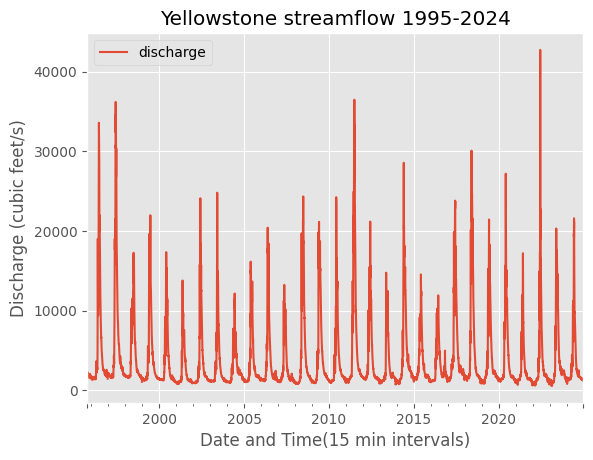

In [176]:

discharge.plot()
plt.title('Yellowstone streamflow 1995-2024')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Date and Time(15 min intervals)')

In [177]:
discharge_2008 = discharge[(discharge.index >= '2008-01-01') & (discharge.index < '2009-01-01')]
discharge_2014 = discharge[(discharge.index >= '2014-01-01') & (discharge.index < '2015-01-01')]
discharge_2020 = discharge[(discharge.index >= '2020-01-01') & (discharge.index < '2021-01-01')]

Text(0.5, 0, 'Date')

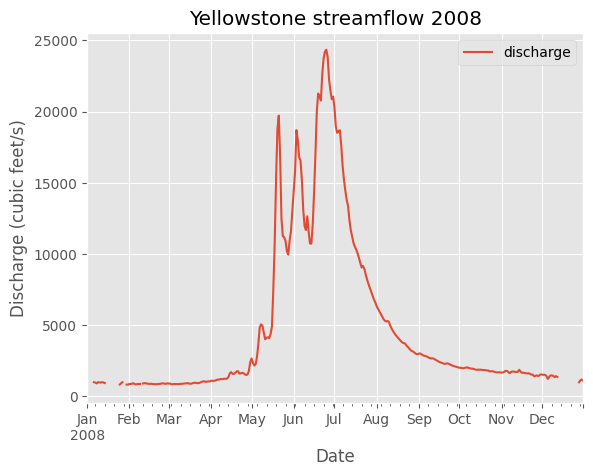

In [178]:
discharge_2008.plot()
plt.title('Yellowstone streamflow 2008')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

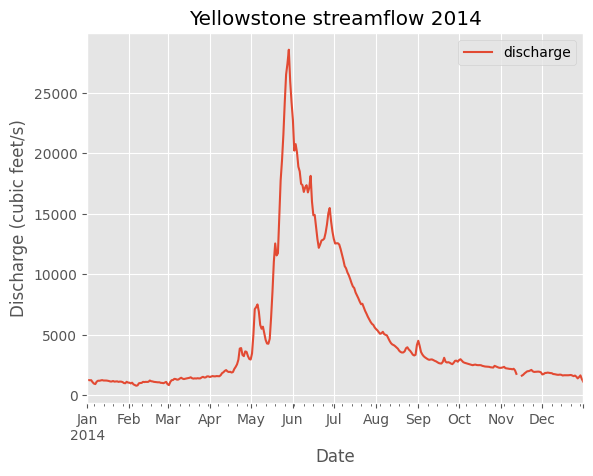

In [179]:
discharge_2014.plot()
plt.title('Yellowstone streamflow 2014')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

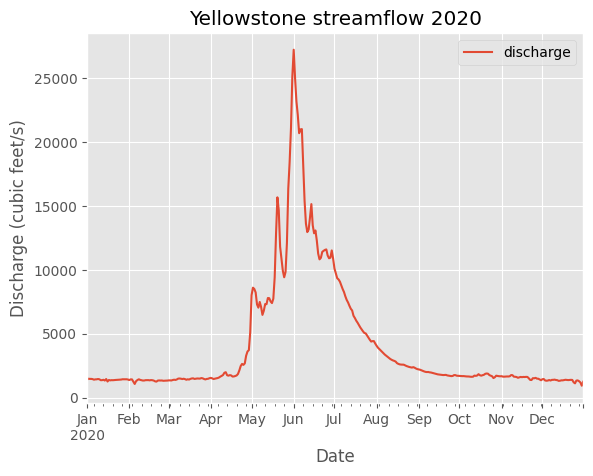

In [180]:
discharge_2020.plot()
plt.title('Yellowstone streamflow 2020')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Date')

From looking at three different years, we can see that there is a similar pattern where the discharge increases during the month of may.  The peaks are different though.  2008 had multiple peaks whereas 2014 and 2021 has single peaks.

In [181]:
discharge['day_of_year']=discharge.index.day_of_year
discharge['week']=discharge.index.isocalendar().week.astype('int32')
discharge['month']=discharge.index.month
discharge['quarter']=discharge.index.quarter
discharge['year']=discharge.index.year
discharge['canyon_snow']=data['canyon_snow']

In [182]:
discharge_consolidated = discharge.copy()
discharge_consolidated = discharge_consolidated.groupby(['year', 'day_of_year']).first()

([<matplotlib.axis.XTick at 0x734d165d6090>,
 [Text(0, 0, '1'),
  Text(5, 0, '6'),
  Text(10, 0, '11'),
  Text(15, 0, '16'),
  Text(20, 0, '21'),
  Text(25, 0, '26'),
  Text(30, 0, '31'),
  Text(35, 0, '36'),
  Text(40, 0, '41'),
  Text(45, 0, '46'),
  Text(50, 0, '51')])

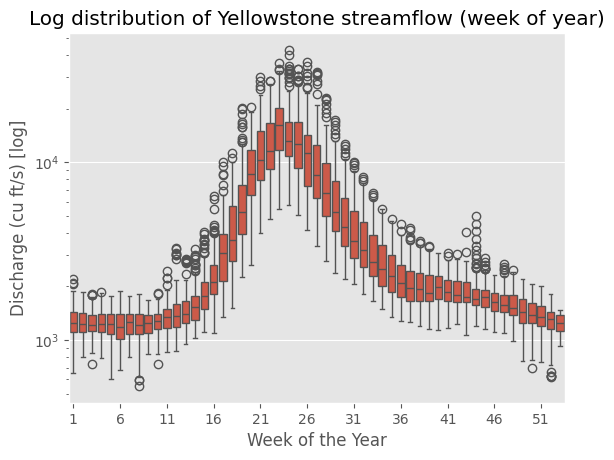

In [183]:
sns.boxplot(data=discharge_consolidated, x='week', y='discharge')
plt.ylabel('Discharge (cu ft/s) [log]')
plt.xlabel('Week of the Year')
plt.yscale('log')
plt.title('Log distribution of Yellowstone streamflow (week of year)')

plt.xticks(range(0, 53, 5))

Box and whisker plots for each week of the year.  There are many outliers during the spring and summer months.  This fits with what we already saw earlier that there is a lot of variability in the peak discharge for a given year.

Text(0.5, 1.0, 'Log distribution of Yellowstone streamflow (month of year)')

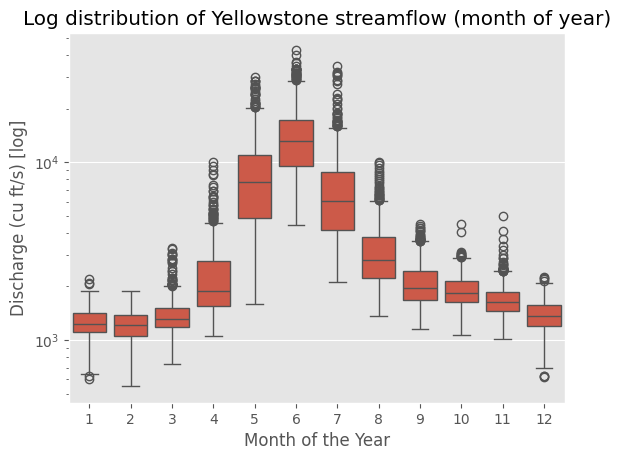

In [184]:
sns.boxplot(data=discharge_consolidated,x='month', y='discharge')
plt.ylabel('Discharge (cu ft/s) [log]')
plt.xlabel('Month of the Year')
plt.yscale('log')
plt.title('Log distribution of Yellowstone streamflow (month of year)')

Similar to the previous plot.  This plot is aggregating the data by month.  We can reach a similar conclusion though.  There is a lot of variability in the peak discharge for a given year.

# Prediction
This is an effort to predict the spring increase in discharge.  The data is from the Yellowstone river at Livingston MT. The data is from the USGS and is available at https://waterdata.usgs.gov/mt/nwis/uv?site_no=06192500   

Ideally we would like to predict both the onset of the spring increase and the peak discharge.   

In [185]:
train = discharge[discharge['year']<2023]
test = discharge[discharge['year']>=2023]

Text(0, 0.5, 'Discharge (cu ft/s)')

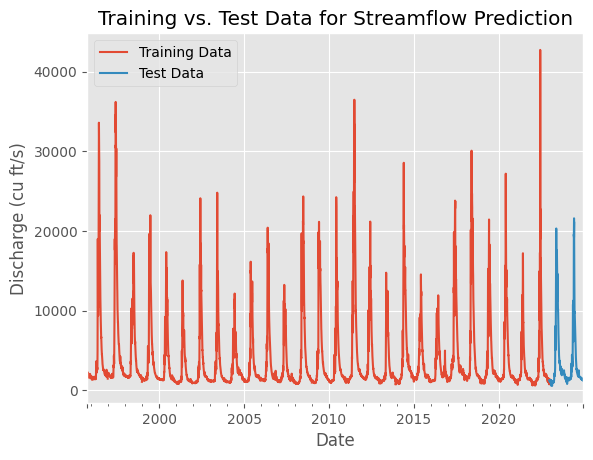

In [186]:
fig, ax = plt.subplots()
train['discharge'].plot(ax=ax)
test['discharge'].plot(ax=ax)
plt.legend(['Training Data', 'Test Data'])
plt.title('Training vs. Test Data for Streamflow Prediction')
plt.xlabel('Date')
plt.ylabel('Discharge (cu ft/s)')

The model will be trained on data from the years preceeding 2023.  The model will be tested on the 2023-2024 data.  

In [193]:
features = ['month','week', 'day_of_year']
target = 'discharge'

x_train = train[features]
y_train = train[target]

x_test = test[features]
y_test = test[target]

In [194]:
# Remove NaN values from x_train, y_train, x_test, and y_test
x_train = x_train.dropna()
y_train = y_train.dropna()
x_test = x_test.dropna()
y_test = y_test.dropna()

# Ensure x_train and y_train match the indices of each other
common_index_train = x_train.index.intersection(y_train.index)
x_train = x_train.loc[common_index_train]
y_train = y_train.loc[common_index_train]

# Ensure x_test and y_test match the indices of each other
common_index_test = x_test.index.intersection(y_test.index)
x_test = x_test.loc[common_index_test]
y_test = y_test.loc[common_index_test]

# Ensure x_train and y_train have the same length
assert len(x_train) == len(y_train), "x_train and y_train must have the same length"

# Ensure x_test and y_test have the same length
assert len(x_test) == len(y_test), "x_test and y_test must have the same length"


regressor = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=100)
eval_set = [(x_train, y_train), (x_test, y_test)]
regressor.fit(x_train, y_train, eval_set=eval_set, verbose=20)

[0]	validation_0-rmse:3860.37016	validation_1-rmse:3126.75243
[20]	validation_0-rmse:2529.66341	validation_1-rmse:1470.25669
[40]	validation_0-rmse:2527.09370	validation_1-rmse:1471.95990
[60]	validation_0-rmse:2526.50330	validation_1-rmse:1473.11145
[80]	validation_0-rmse:2526.23499	validation_1-rmse:1473.74064
[100]	validation_0-rmse:2526.14234	validation_1-rmse:1474.32008
[116]	validation_0-rmse:2526.04611	validation_1-rmse:1474.25914


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [195]:
pd.set_option('mode.chained_assignment', None)

# Reindex x_test to match the index of test
x_test_reindexed = x_test.reindex(test.index)

# Make predictions
test['prediction'] = regressor.predict(x_test_reindexed)

[0]	validation_0-rmse:3860.37016	validation_1-rmse:3126.75243


[20]	validation_0-rmse:2529.66341	validation_1-rmse:1470.25669
[40]	validation_0-rmse:2527.09370	validation_1-rmse:1471.95990
[60]	validation_0-rmse:2526.50330	validation_1-rmse:1473.11145
[80]	validation_0-rmse:2526.23499	validation_1-rmse:1473.74064
[100]	validation_0-rmse:2526.14234	validation_1-rmse:1474.32008
[116]	validation_0-rmse:2526.04611	validation_1-rmse:1474.25914


Text(0.5, 1.0, 'Feature Importance')

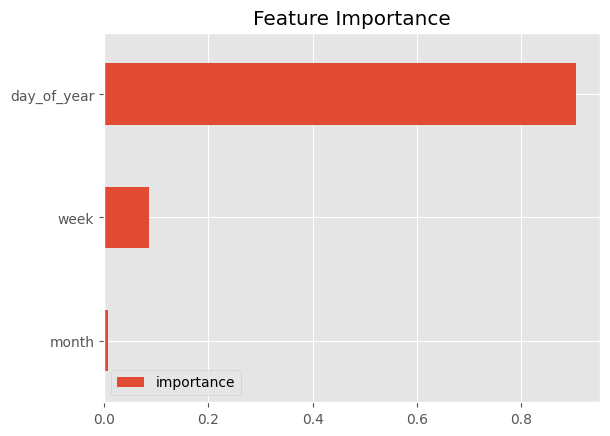

In [196]:
# Ensure all feature names are strings
x_train.columns = x_train.columns.astype(str)
x_test.columns = x_test.columns.astype(str)

# Refit the model with updated feature names
regressor.fit(x_train, y_train, eval_set=eval_set, verbose=20)

# Plot feature importance
importance = pd.DataFrame(data=regressor.feature_importances_, index=regressor.get_booster().feature_names,
            columns=['importance'])
importance = importance.sort_values('importance')
importance.plot.barh()
plt.title('Feature Importance')

The day of the year is the most important variable in predicting the onset of the discharge.

Text(0.5, 1.0, 'Model vs. 2023 Discharge Data')

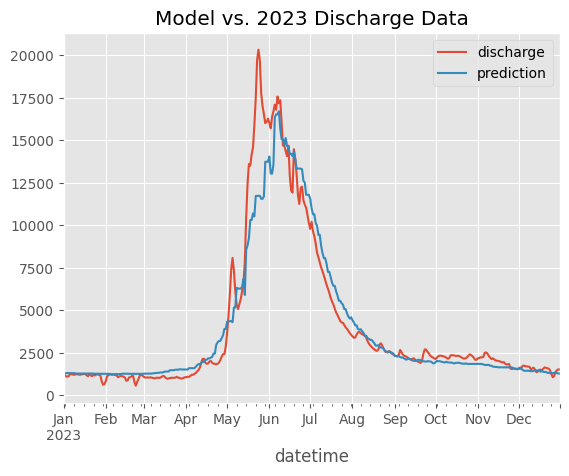

In [197]:
predicted_2023 = test[test['year'] == 2023]
predicted_2023.plot(y=['discharge', 'prediction'])
plt.title('Model vs. 2023 Discharge Data')

This is a plot of the model prediction vs the actual 2023 data.  The timing of the onset looks really good.  However, the peak discharge is off a bit.

Text(0.5, 1.0, 'Model vs. 2024 Discharge Data')

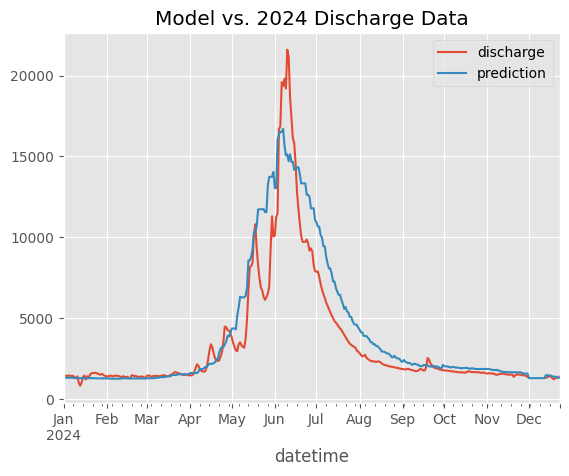

In [198]:
predicted_2024 = test[test['year'] == 2024]
predicted_2024.plot(y=['discharge', 'prediction'])
plt.title('Model vs. 2024 Discharge Data')

Like the 2023 data, the model prediction for the 2024 data looks good for the onset of the discharge.  The peak discharge is off a bit again.  It seems that the model is underpredicting the peak discharge.  I suspect that this has something to do with the amount of snowpack in the mountains.  This is a potential future question to investigate.  Average daily temperatures could also be a useful variable to include in the model.  This should be the next step in improving the model.

In [202]:
print(data.columns)

Index(['datetime', 'id', 'discharge', 'gage_height', 'canyon_snow',
       'northeast_entrance_snow', 'parker_peak_snow', 'sylvan_lake_snow',
       'thumb_divide_snow', 'usw00024150_tmax', 'usw00024150_tmin',
       'usc00485345_tmax', 'usc00485345_tmin', 'year', 'month', 'day',
       'day_of_year'],
      dtype='object')


In [211]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the data into training and testing sets
train = data[data['year']<2023]
test = data[data['year']>=2023]

# Define features and target
features = ['year', 'day_of_year', 'month', 'canyon_snow', 'northeast_entrance_snow', 
            'parker_peak_snow', 'sylvan_lake_snow', 'thumb_divide_snow', 'usw00024150_tmin', 
            'usw00024150_tmax', 'usc00485345_tmin', 'usc00485345_tmax']
target = 'discharge'

# Split the data into training and testing sets
x_train = train[features]
y_train = train[target]

x_test = test[features]
y_test = test[target]

# Remove NaN values from x_train, y_train, x_test, and y_test
x_train = x_train.dropna()
y_train = y_train.dropna()
x_test = x_test.dropna()
y_test = y_test.dropna()

# Ensure x_train and y_train match the indices of each other
common_index_train = x_train.index.intersection(y_train.index)
x_train = x_train.loc[common_index_train]
y_train = y_train.loc[common_index_train]

# Ensure x_test and y_test match the indices of each other
common_index_test = x_test.index.intersection(y_test.index)
x_test = x_test.loc[common_index_test]
y_test = y_test.loc[common_index_test]

# Ensure x_train and y_train have the same length
assert len(x_train) == len(y_train), "x_train and y_train must have the same length"

# Ensure x_test and y_test have the same length
assert len(x_test) == len(y_test), "x_test and y_test must have the same length"


regressor = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=100)
eval_set = [(x_train, y_train), (x_test, y_test)]
regressor.fit(x_train, y_train, eval_set=eval_set, verbose=20)


[0]	validation_0-rmse:3587.87425	validation_1-rmse:2454.23170
[20]	validation_0-rmse:773.51669	validation_1-rmse:1235.40405
[40]	validation_0-rmse:546.96792	validation_1-rmse:1300.50356
[60]	validation_0-rmse:394.30763	validation_1-rmse:1329.88493
[80]	validation_0-rmse:325.80140	validation_1-rmse:1335.62046
[100]	validation_0-rmse:262.51020	validation_1-rmse:1333.36782
[107]	validation_0-rmse:244.21259	validation_1-rmse:1339.73396


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [212]:
pd.set_option('mode.chained_assignment', None)

# Reindex x_test to match the index of test
x_test_reindexed = x_test.reindex(test.index)

# Make predictions
test['prediction'] = regressor.predict(x_test_reindexed)

[0]	validation_0-rmse:3587.87425	validation_1-rmse:2454.23170
[20]	validation_0-rmse:773.51669	validation_1-rmse:1235.40405
[40]	validation_0-rmse:546.96792	validation_1-rmse:1300.50356
[60]	validation_0-rmse:394.30763	validation_1-rmse:1329.88493
[80]	validation_0-rmse:325.80140	validation_1-rmse:1335.62046
[100]	validation_0-rmse:262.51020	validation_1-rmse:1333.36782
[107]	validation_0-rmse:244.21259	validation_1-rmse:1339.73396


Text(0.5, 1.0, 'Feature Importance')

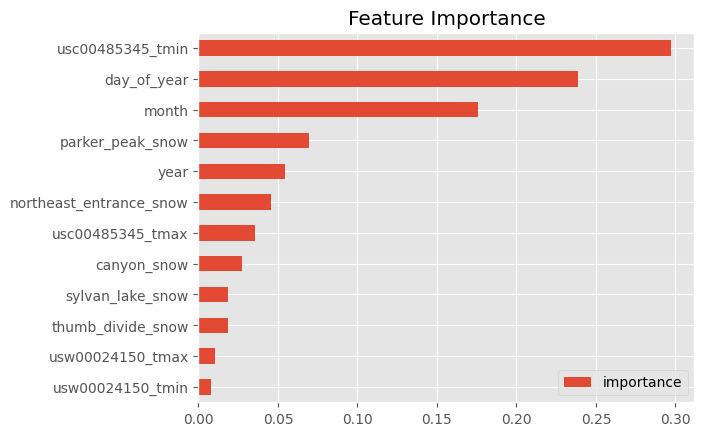

In [213]:
# Ensure all feature names are strings
x_train.columns = x_train.columns.astype(str)
x_test.columns = x_test.columns.astype(str)

# Refit the model with updated feature names
regressor.fit(x_train, y_train, eval_set=eval_set, verbose=20)

# Plot feature importance
importance = pd.DataFrame(data=regressor.feature_importances_, index=regressor.get_booster().feature_names,
            columns=['importance'])
importance = importance.sort_values('importance')
importance.plot.barh()
plt.title('Feature Importance')

Interesting!  Tmin and day of year are important

Text(0.5, 1.0, 'Model vs. 2023 Discharge Data')

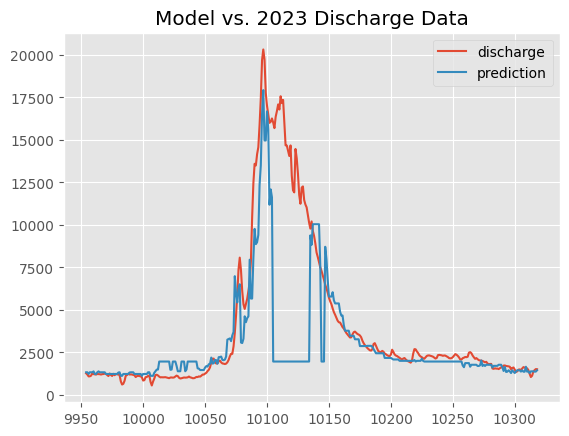

In [214]:
predicted_2023 = test[test['year'] == 2023]
predicted_2023.plot(y=['discharge', 'prediction'])
plt.title('Model vs. 2023 Discharge Data')

Text(0.5, 1.0, 'Model vs. 2024 Discharge Data')

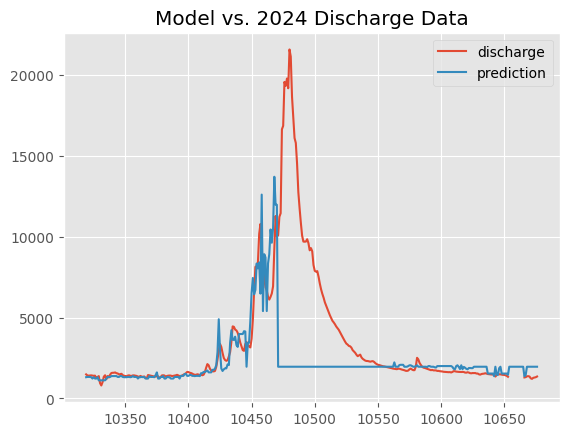

In [215]:
predicted_2024 = test[test['year'] == 2024]
predicted_2024.plot(y=['discharge', 'prediction'])
plt.title('Model vs. 2024 Discharge Data')

Giving the model more data seems to have made the model worse!  